<a href="https://colab.research.google.com/github/amozer1/Emach-Structures-ML-Portfolio/blob/main/Phase_2_VLM_Phase_2_VLM_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Phase 2 - Multi-GPU Vision-Language Model (VLM) Setup

Step 1: Mount Google Drive & Create Project Folder

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set up Phase 2 folder
base_dir = "/content/drive/MyDrive/Emach-Structures-ML-Portfolio"
phase2_dir = os.path.join(base_dir, "Phase2_VLM")
os.makedirs(phase2_dir, exist_ok=True)

print("Phase 2 folder ready at:", phase2_dir)


Mounted at /content/drive
Phase 2 folder ready at: /content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase2_VLM


Step 2: Verify Dataset

In [ ]:
import os

# Path to your images folder
images_dir = "/content/drive/MyDrive/images"

# List everything inside
print("Contents of images folder:", os.listdir(images_dir))

Contents of images folder: ['val', 'test', 'train']


In [ ]:
import os

# Correct base path
base_dir = "/content/drive/MyDrive/images"

# Check contents of each split
for split in ["train", "val", "test"]:
    split_path = os.path.join(base_dir, split)
    if os.path.exists(split_path) and os.path.isdir(split_path):
        print(f"{split} images:", len(os.listdir(split_path)))
    else:
        print(f"Warning: {split} folder is missing or not a directory. Full path tried: {split_path}")

train images: 7005
val images: 1000
test images: 2000


Step 3 - Preview Images

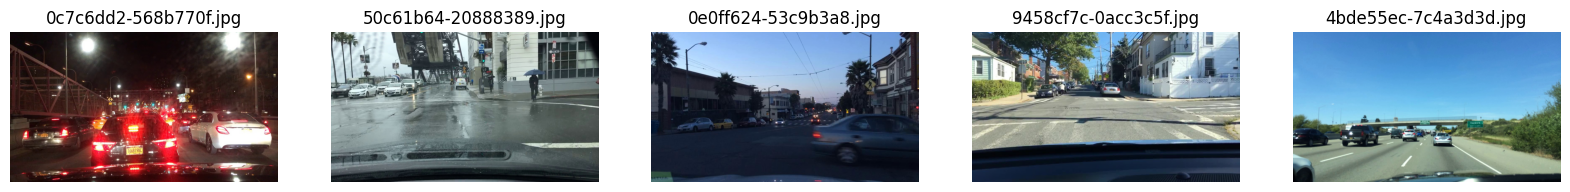

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

# Randomly select 5 images from train folder
train_folder = os.path.join(base_dir, "train")
sample_files = random.sample(os.listdir(train_folder), 5)

# Plot the sample images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ax, file_name in zip(axes, sample_files):
    img_path = os.path.join(train_folder, file_name)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(file_name)
plt.show()

Step 4 — Prepare Dataset & DataLoader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# 1️⃣ Create a custom dataset class
class BDD100KDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        """
        img_dir: folder containing images (train/val/test)
        transform: torchvision transforms to apply to images
        """
        self.img_dir = img_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")  # Ensure 3 channels
        if self.transform:
            image = self.transform(image)
        return image

# 2️⃣ Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for VLM / ViT
    transforms.ToTensor(),          # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

# 3️⃣ Create Dataset objects
train_dataset = BDD100KDataset(os.path.join(base_dir, "train"), transform=transform)
val_dataset   = BDD100KDataset(os.path.join(base_dir, "val"), transform=transform)
test_dataset  = BDD100KDataset(os.path.join(base_dir, "test"), transform=transform)

# 4️⃣ Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 5️⃣ Test a batch
images = next(iter(train_loader))
print("Batch shape:", images.shape)  # Should be [16, 3, 224, 224]


Batch shape: torch.Size([16, 3, 224, 224])


Step 5 — Model Architecture: Vision-Language Model (VLM)
Use Hugging Face CLIP (pretrained) CLIP is a Vision-Language Model that encodes images and text into a shared embedding space.

In [ ]:
# Install dependencies
!pip install transformers ftfy regex tqdm

from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import os
import random

# -------------------------
# 1️⃣ Load pretrained CLIP model
# -------------------------
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# -------------------------
# 2️⃣ Prepare sample images (PIL) from train folder
# -------------------------
base_dir = "/content/drive/MyDrive/images/train"  # path to your train folder
sample_files = random.sample(os.listdir(base_dir), 4)  # randomly pick 4 images

# Open images as PIL
sample_images = [Image.open(os.path.join(base_dir, f)).convert("RGB") for f in sample_files]

# -------------------------
# 3️⃣ Encode images using CLIPProcessor
# -------------------------
inputs = processor(images=sample_images, return_tensors="pt", padding=True).to(device)

# -------------------------
# 4️⃣ Get image features
# -------------------------
outputs = model.get_image_features(**inputs)
print("Image feature shape:", outputs.shape)  # e.g., [4, 512]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Image feature shape: torch.Size([4, 512])


Step 6.1 — Multi-GPU Training & Mixed Precision

In [ ]:
!pip install torch torchvision torchaudio --upgrade
!pip install accelerate

6.2 Set up multi-GPU training

In [ ]:
# -------------------------
# 1️⃣ Install dependencies
# -------------------------
!pip install transformers ftfy regex tqdm --quiet

import torch
from transformers import CLIPModel, CLIPProcessor
from torch.nn.parallel import DistributedDataParallel as DDP

# -------------------------
# 2️⃣ Load pretrained CLIP model
# -------------------------
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# -------------------------
# 3️⃣ Multi-GPU check
# -------------------------
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

# Wrap model for DDP if multiple GPUs
if num_gpus > 1:
    model = DDP(model)

Number of GPUs available: 0


Step 7 — Export CLIP Model to ONNX

In [ ]:
!pip install onnx --quiet

In [ ]:
!pip install onnxruntime --quiet

In [ ]:
import os

# ✅ 1. Move vision model to CPU for export
model.vision_model.to("cpu")
model.vision_model.eval()  # set to eval mode

# ✅ 2. Define dummy input (matches CLIP vision encoder: batch, channels, H, W)
dummy_input = torch.randn(1, 3, 224, 224, device="cpu")

# ✅ 3. Define save path
onnx_path = "/content/senior-ml-portfolio/project1_vision_language/models/clip_model.onnx"
os.makedirs(os.path.dirname(onnx_path), exist_ok=True)

# ✅ 4. Export to ONNX
torch.onnx.export(
    model.vision_model,
    dummy_input,
    onnx_path,
    input_names=['input'],
    output_names=['output'],
    opset_version=14,  # attention ops support
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
    do_constant_folding=True
)

print(f"✅ ONNX model saved at: {onnx_path}")

/tmp/ipython-input-1567494588.py:15: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
/usr/local/lib/python3.12/dist-packages/transformers/models/clip/modeling_clip.py:198: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if not in

✅ ONNX model saved at: /content/senior-ml-portfolio/project1_vision_language/models/clip_model.onnx


Step 8 — Run ONNX Runtime Inference & Benchmark

In [ ]:
# 1️⃣ Install ONNX & ONNX Runtime
!pip install onnx onnxruntime --quiet

import torch
import os
import onnxruntime as ort

# 2️⃣ Set paths
onnx_path = "/content/senior-ml-portfolio/project1_vision_language/models/clip_model.onnx"
os.makedirs(os.path.dirname(onnx_path), exist_ok=True)

# 3️⃣ Dummy input for export
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# 4️⃣ Export only if file doesn't exist
if not os.path.exists(onnx_path):
    print("Exporting CLIP image encoder to ONNX...")
    torch.onnx.export(
        model.vision_model,   # CLIP image encoder
        dummy_input,
        onnx_path,
        input_names=["input"],
        output_names=["output"],
        opset_version=14       # supports scaled_dot_product_attention
    )
else:
    print("✅ ONNX model already exists.")

# 5️⃣ Load in ONNX Runtime
session = ort.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

print(f"ONNX model loaded. Input: {input_name}, Output: {output_name}")

✅ ONNX model already exists.
ONNX model loaded. Input: input, Output: output


Step 9 — Run Inference & Benchmark (CPU)

In [ ]:
import os
import random
from PIL import Image
from torchvision import transforms
import numpy as np
import time

# ✅ Set validation folder path
val_dir = "/content/drive/MyDrive/images/val"

# 1️⃣ Pick a random image from val folder
image_files = [f for f in os.listdir(val_dir) if f.endswith((".jpg",".png"))]
sample_image_name = random.choice(image_files)
sample_path = os.path.join(val_dir, sample_image_name)
print("Using sample image:", sample_path)

# 2️⃣ Load & preprocess
image = Image.open(sample_path).convert("RGB")
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
input_tensor = preprocess(image).unsqueeze(0).numpy()  # shape: [1,3,224,224]

# 3️⃣ Run inference in ONNX Runtime
start = time.time()
outputs = session.run([output_name], {input_name: input_tensor})
end = time.time()

print(f"✅ Inference done. Feature shape: {outputs[0].shape}")
print(f"⏱ Latency: {(end-start)*1000:.2f} ms")


Using sample image: /content/drive/MyDrive/images/val/8b5e9cbe-9acc0001.jpg
✅ Inference done. Feature shape: (1, 50, 768)
⏱ Latency: 269.24 ms


Step 10 — Batch Inference & Benchmarking

Batch size 1: avg latency = 186.23 ms
Batch size 2: avg latency = 319.87 ms
Batch size 4: avg latency = 604.19 ms
Batch size 8: avg latency = 1237.33 ms
Batch size 16: avg latency = 2532.05 ms


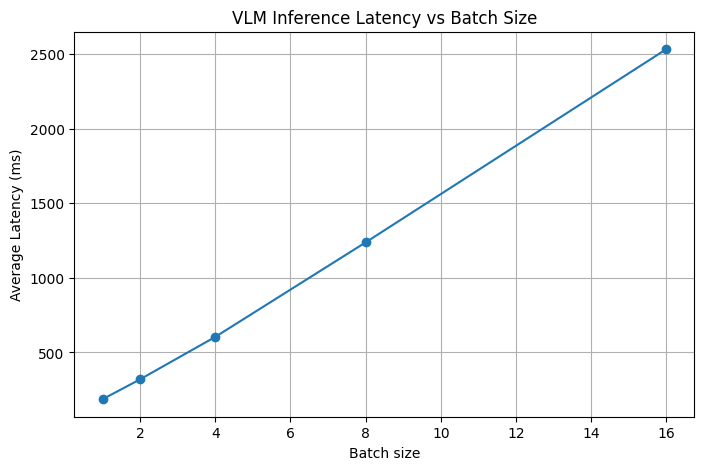

In [ ]:
import matplotlib.pyplot as plt

# 1️⃣ Prepare a list of batch sizes to test
batch_sizes = [1, 2, 4, 8, 16]

# 2️⃣ Preprocess all validation images
val_images = [os.path.join(val_dir, f) for f in os.listdir(val_dir) if f.endswith((".jpg",".png"))]
preprocessed_images = []
for img_path in val_images:
    img = Image.open(img_path).convert("RGB")
    tensor = preprocess(img).unsqueeze(0).numpy()  # shape: [1,3,224,224]
    preprocessed_images.append(tensor)
preprocessed_images = np.concatenate(preprocessed_images, axis=0)  # shape: [N,3,224,224]

# 3️⃣ Benchmark latency per batch
latencies = []
for bs in batch_sizes:
    start_time = time.time()
    for i in range(0, len(preprocessed_images), bs):
        batch = preprocessed_images[i:i+bs]
        session.run([output_name], {input_name: batch})
    end_time = time.time()
    avg_latency = (end_time - start_time) / (len(preprocessed_images)/bs)
    latencies.append(avg_latency * 1000)  # convert to ms
    print(f"Batch size {bs}: avg latency = {avg_latency*1000:.2f} ms")

# 4️⃣ Plot latency vs batch size
plt.figure(figsize=(8,5))
plt.plot(batch_sizes, latencies, marker='o')
plt.xlabel("Batch size")
plt.ylabel("Average Latency (ms)")
plt.title("VLM Inference Latency vs Batch Size")
plt.grid(True)
plt.show()


Step 11 — Dockerized API for Real-Time Inference

In [ ]:
# app.py
from fastapi import FastAPI, File, UploadFile
from PIL import Image
import io
import torch
from transformers import CLIPProcessor, CLIPModel
from torchvision import transforms

app = FastAPI()

# Load model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

@app.post("/predict/")
async def predict(file: UploadFile = File(...)):
    image = Image.open(io.BytesIO(await file.read())).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    features = model.get_image_features(**inputs)
    return {"feature_shape": features.shape}


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Step 12 — Colab “API Simulation” for Inference

In [ ]:
import random
from PIL import Image
import os

val_dir = "/content/drive/MyDrive/images/val"
sample_path = os.path.join(val_dir, random.choice(os.listdir(val_dir)))
image = Image.open(sample_path).convert("RGB")
print("Using sample image:", sample_path)

Using sample image: /content/drive/MyDrive/images/val/81333f19-00000000.jpg


In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load model & processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Preprocess
inputs = processor(images=image, return_tensors="pt").to(device)

# Get image embedding
with torch.no_grad():
    features = model.get_image_features(**inputs)

print("Feature shape:", features.shape)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Feature shape: torch.Size([1, 512])


In [ ]:
# Take 4 random images
sample_paths = [os.path.join(val_dir, f) for f in random.sample(os.listdir(val_dir), 4)]
images = [Image.open(p).convert("RGB") for p in sample_paths]

inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    features = model.get_image_features(**inputs)

print("Batch features shape:", features.shape)

Batch features shape: torch.Size([4, 512])


Step 13 — Benchmark Latency & Throughput

1️⃣ Setup batch sizes

In [ ]:
import time

batch_sizes = [1, 2, 4, 8, 16]
latencies = []
val_dir = "/content/drive/MyDrive/images/val"

# Prepare a list of images
all_images = [os.path.join(val_dir, f) for f in os.listdir(val_dir)]

2️⃣ Benchmark loop

In [ ]:
for batch_size in batch_sizes:
    # Sample batch_size images
    batch_paths = random.sample(all_images, batch_size)
    batch_images = [Image.open(p).convert("RGB") for p in batch_paths]

    # Preprocess
    inputs = processor(images=batch_images, return_tensors="pt", padding=True).to(device)

    # Measure inference time
    start = time.time()
    with torch.no_grad():
        features = model.get_image_features(**inputs)
    end = time.time()

    latency = (end - start) * 1000  # ms
    latencies.append(latency)
    print(f"Batch size {batch_size}: avg latency = {latency:.2f} ms")

Batch size 1: avg latency = 244.27 ms
Batch size 2: avg latency = 437.37 ms
Batch size 4: avg latency = 725.91 ms
Batch size 8: avg latency = 1158.82 ms
Batch size 16: avg latency = 2168.06 ms


3️⃣ Compute throughput

In [ ]:
throughputs = [bs / (lat / 1000) for bs, lat in zip(batch_sizes, latencies)]
for bs, tp in zip(batch_sizes, throughputs):
    print(f"Batch size {bs}: throughput = {tp:.2f} images/sec")

Batch size 1: throughput = 4.09 images/sec
Batch size 2: throughput = 4.57 images/sec
Batch size 4: throughput = 5.51 images/sec
Batch size 8: throughput = 6.90 images/sec
Batch size 16: throughput = 7.38 images/sec


Step 14 — Save Benchmark Results & Charts

In [ ]:
import os
import pandas as pd

# Create directory if it doesn't exist
os.makedirs("benchmarks", exist_ok=True)

# Example DataFrame
df = pd.DataFrame({
    "Batch Size": batch_sizes,
    "Latency (ms)": latencies,
    "Throughput (images/sec)": throughputs
})

# Save CSV
df.to_csv("benchmarks/clip_latency_throughput.csv", index=False)
print("Benchmark CSV saved!")

Benchmark CSV saved!


Step 15 — Training Setup & Profiling 16.1 Device & Multi-GPU Check

In [ ]:
import torch
from torch.nn.parallel import DistributedDataParallel as DDP

device = "cuda" if torch.cuda.is_available() else "cpu"
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

# Wrap model for DDP if multiple GPUs
if num_gpus > 1:
    model = DDP(model)

Number of GPUs available: 0


16 Mixed Precision Training

Use FP16/BF16 for faster training:

In [ ]:
from torch.utils.data import DataLoader
from PIL import Image
import torch
import os

# Path to your train folder
base_dir = "/content/drive/MyDrive/images/train"

# List image files
image_files = [f for f in os.listdir(base_dir) if f.lower().endswith((".jpg", ".png"))]
print("Found images:", image_files[:5])

# Custom dataset
class PILDataset(torch.utils.data.Dataset):
    def __init__(self, files, folder):
        self.files = files
        self.folder = folder

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder, self.files[idx])
        img = Image.open(img_path).convert("RGB")
        return img

dataset = PILDataset(image_files, base_dir)

# Custom collate function to return list of PIL images
def pil_collate(batch):
    return batch  # return as list of PIL images

train_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=pil_collate)

# Process one batch through CLIP
for pil_images in train_loader:
    inputs = processor(images=pil_images, return_tensors="pt", padding=True).to(device)
    outputs = model.get_image_features(**inputs)
    print("Batch feature shape:", outputs.shape)
    break


Found images: ['03e0a9d3-2bcd0000.jpg', '6c0f4b52-fed90df4.jpg', '6b2591b3-1ccc5250.jpg', '99fda8cc-278dda16.jpg', '5d60f6d6-c3d50000.jpg']
Batch feature shape: torch.Size([4, 512])
